# Week 03 Feature Engineering

In [33]:
import pandas as pd
import numpy as np
import ta as ta

In [34]:
row_data_path = '../../data/row/'
processed_data_path = '../../data/processed/'
NVDA_5_years_daily_data = pd.read_csv(
    row_data_path + 'NVDA_5_years_daily_data.csv', index_col='date', parse_dates=True)

[Technical Analysis Library in Python](https://github.com/bukosabino/ta) 

Example adding all features:

In [ ]:
df = ta.add_all_ta_features(df=NVDA_5_years_daily_data.copy(), 
                            open="1. open",
                            high="2. high",
                            low="3. low",
                            close="5. adjusted close",
                            volume="6. volume")

1. Convert volume to log space

In [48]:
NVDA_5_years_daily_data['log_volume'] = np.log(NVDA_5_years_daily_data['6. volume'])

2. Compute daily returns (difference)

In [49]:
NVDA_5_years_daily_data['daily_returns'] = NVDA_5_years_daily_data['5. adjusted close'].diff()

3. Calculate MA-5

Moving Average(MA)

<Axes: title={'center': 'NVDA Close Prices and MA-5'}, xlabel='date'>

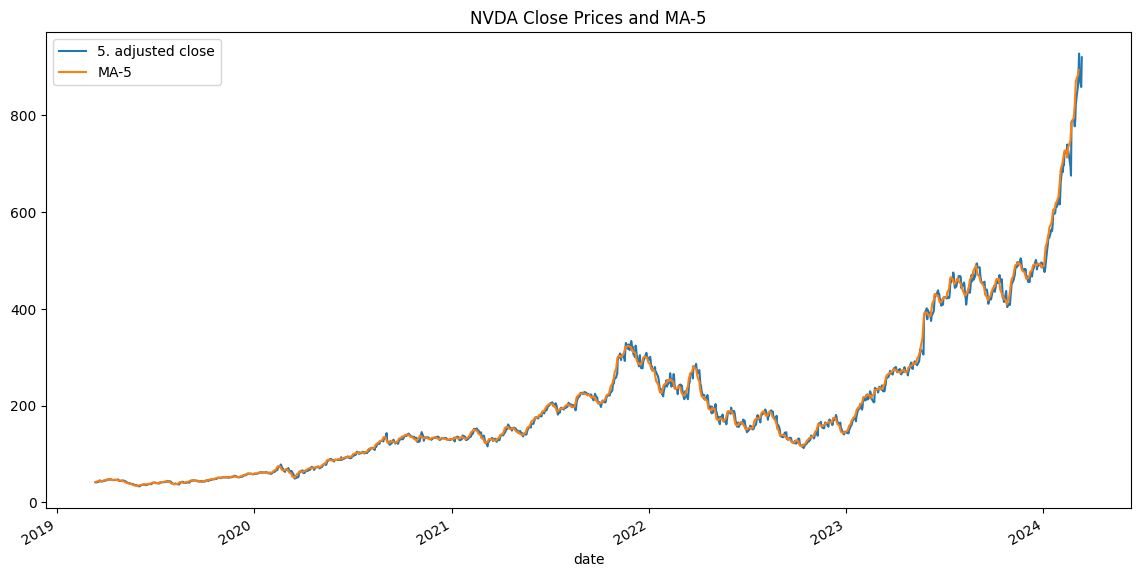

In [50]:
NVDA_5_years_daily_data['MA-5'] = NVDA_5_years_daily_data['5. adjusted close'].rolling(
    window=5).mean()

# Plotting MA-5 as an example
NVDA_5_years_daily_data[['5. adjusted close', 'MA-5']
                        ].plot(figsize=(14, 7), title="NVDA Close Prices and MA-5")

4. Calculate MA-30

In [51]:
NVDA_5_years_daily_data['MA-30'] = NVDA_5_years_daily_data['5. adjusted close'].rolling(
    window=30).mean()

5. Calculate Relative Strength Index (RSI)

The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.

The RSI can do more than point to overbought and oversold securities. It can also indicate securities that may be primed for a trend reversal or corrective pullback in price. It can signal when to buy and sell. Traditionally, 
- an RSI reading of 70 or above indicates an overbought situation. 
- A reading of 30 or below indicates an oversold condition.

When date number doesn't accumulate to 14:

$$
R S I_{\text {step one }}=100-\left[\frac{100}{1+\frac{\text { Average gain }}{\text { Average loss }}}\right]
$$

Once there are 14 periods of data available, the second calculation can be done. 

$$
R S I_{\text {step two }}=100-\left[\frac{100}{1+\frac{\text { (Previous Average Gain } \times 13)+ \text { Current Gain }}{(\text { (Previous Average Loss } \times 13)+\text { Current Loss })}}\right]
$$

In [52]:
RSI = ta.momentum.RSIIndicator(
    NVDA_5_years_daily_data['5. adjusted close'], window=14)
NVDA_5_years_daily_data['RSI'] = RSI.rsi()

6. Calculate 5-day variance

In [53]:
NVDA_5_years_daily_data['5-day_variance'] = NVDA_5_years_daily_data['5. adjusted close'].rolling(
    window=5).var()

7. Calculate Williams %R

Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. 

The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way. It was developed by Larry Williams and it compares a stock’s closing price to the high-low range over a specific period, typically 14 days or periods.

The Formula for the Williams \%R Is:
$$
\text { Wiliams } \% R=\frac{\text { Highest High }- \text { Close }}{\text { Highest High }- \text { Lowest Low }}
$$

In [54]:
WILLR = ta.momentum.WilliamsRIndicator(high=NVDA_5_years_daily_data['2. high'],
                                       low=NVDA_5_years_daily_data['3. low'],
                                       close=NVDA_5_years_daily_data['5. adjusted close'],
                                       lbp=14)
NVDA_5_years_daily_data['Williams_%R'] = WILLR.williams_r()

8. Calculate z-score for daily close prices

$$
Z = \frac{x - \mu}{\sigma}
$$

In [55]:
NVDA_5_years_daily_data['z_score'] = (NVDA_5_years_daily_data['5. adjusted close'] - NVDA_5_years_daily_data['5. adjusted close'].mean()) / NVDA_5_years_daily_data['5. adjusted close'].std()

In [56]:
# Save the enhanced dataset
NVDA_5_years_daily_data.to_csv(processed_data_path + 'features_NVDA.csv')

print("Enhanced dataset saved successfully.")

Enhanced dataset saved successfully.
